# Project Notebook

## General Imports

In [ ]:
import os
import json
import traceback

## Import the fablib Library

In [1]:
from fabrictestbed_extensions.fablib.fablib import FablibManager as fablib_manager
fablib = fablib_manager() 
conf = fablib.show_config()

Credential Manager,cm.fabric-testbed.net
Orchestrator,orchestrator.fabric-testbed.net
Token File,/home/fabric/.tokens.json
Project ID,6ce270de-788d-4e07-8bae-3206860a6387
Bastion Username,jackson_nichols_0000155246
Bastion Private Key File,/home/fabric/work/fabric_config/fabric_bastion_key
Bastion Host,bastion.fabric-testbed.net
Bastion Private Key Passphrase,None
Slice Public Key File,/home/fabric/work/fabric_config/slice_key.pub
Slice Private Key File,/home/fabric/work/fabric_config/slice_key
Slice Private Key Passphrase,None


## MFLib Imports

In [ ]:
import mflib 
print(f"MFLib version  {mflib.__version__} " )

from mflib.mflib import MFLib

In [ ]:
from fabrictestbed_extensions.fablib.fablib import FablibManager as fablib_manager

try:
    fablib = fablib_manager()
                    
    fablib.show_config()
except Exception as e:
    print(f"Exception: {e}")

## Establish the sets of nodes

"node_conf" will hold the collection of L3 Nodes
"net_conf" will hold the L2 nodes connecting the L3 Nodes
"route_conf" is the live connections between nodes

In [6]:
#Needs polish
slice_name="topology-test-" + fablib.get_bastion_username()

[site1,site2,site3,site4,site5] = fablib.get_random_sites(count=5, avoid=["CERN","DALL","GPN","LBNL","RENC","SALT","TACC","UKY","WASH","NCSA","LOSA","GATECH","INDI","MAX", "MASS","NEWY","SRI","UCSD"])

node_conf = [
 {'name': "consumer1", 'site': site1, 'cores': 2, 'ram': 4, 'disk': 10, 'image': 'default_ubuntu_20', 'packages': ['net-tools', 'iperf3', 'moreutils']}, 
 {'name': "consumer2", 'site': site2, 'cores': 2, 'ram': 4, 'disk': 10, 'image': 'default_ubuntu_20', 'packages': ['net-tools', 'iperf3', 'moreutils']}, 
 {'name': "server",  'site': site3, 'cores': 2, 'ram': 4, 'disk': 10, 'image': 'default_ubuntu_20', 'packages': ['net-tools', 'iperf3', 'moreutils']}, 
 {'name': "router1", 'site': site4, 'cores': 2, 'ram': 4, 'disk': 10, 'image': 'default_ubuntu_20', 'packages': ['net-tools']}, 
 {'name': "router2", 'site': site5, 'cores': 2, 'ram': 4, 'disk': 10, 'image': 'default_ubuntu_20', 'packages': ['net-tools']}
]

net_conf = [
 {"name": "net_c1r1", "subnet": "10.10.1.0/24", "nodes": [{"name": "consumer1", "addr": "10.10.1.100"}, {"name": "router1", "addr": "10.10.1.10"}]},
 {"name": "net_c1r2", "subnet": "10.10.2.0/24", "nodes": [{"name": "consumer1", "addr": "10.10.2.100"}, {"name": "router2", "addr": "10.10.2.10"}]},
 {"name": "net_c2r2", "subnet": "10.10.3.0/24", "nodes": [{"name": "consumer2", "addr": "10.10.3.100"}, {"name": "router2", "addr": "10.10.3.10"}]},
 {"name": "net_vr1",  "subnet": "10.10.4.0/24", "nodes": [{"name": "server", "addr": "10.10.4.100"}, {"name": "router1", "addr": "10.10.4.10"}]},
 {"name": "net_vr2",  "subnet": "10.10.5.0/24", "nodes": [{"name": "server", "addr": "10.10.5.100"}, {"name": "router2", "addr": "10.10.5.10"}]}
]

route_config = [
    {"addr": "10.10.4.0/24", "gw": "10.10.1.10", "nodes": ["consumer1"]}, #can reach server subnet through router1 gw
    {"addr": "10.10.3.0/24", "gw": "10.10.2.10", "nodes": ["consumer1"]}, #can reach consumer2 subnet through router2 gw
    {"addr": "10.10.5.0/24", "gw": "10.10.2.10", "nodes": ["consumer1"]}, #can reach server subnet through router2 gw
    {"addr": "10.10.1.0/24", "gw": "10.10.3.10", "nodes": ["consumer2"]}, #can reach consumer1 subnet through router2 gw
    {"addr": "10.10.5.0/24", "gw": "10.10.3.10", "nodes": ["consumer2"]}, #can reach server subnet through router2 gw
    {"addr": "10.10.1.0/24", "gw": "10.10.4.10", "nodes": ["server"]}, #can reach consumer1 subnet through router1 gw
    {"addr": "10.10.2.0/24", "gw": "10.10.5.10", "nodes": ["server"]}, #can reach consumer1 subnet through router2 gw
    {"addr": "10.10.3.0/24", "gw": "10.10.5.10", "nodes": ["server"]}  #can reach consumer2 subnet through router2 gw
]

"""
node_conf = [
 {'name': "consumer1", 'site': site1, 'cores': 2, 'ram': 4, 'disk': 10, 'image': 'default_ubuntu_20', 'packages': ['net-tools', 'iperf3', 'moreutils']},
 {'name': "server", 'site': site3, 'cores': 2, 'ram': 4, 'disk': 10, 'image': 'default_ubuntu_20', 'packages': ['net-tools', 'iperf3', 'moreutils']}, 
 {'name': "router1", 'site': site4, 'cores': 2, 'ram': 4, 'disk': 10, 'image': 'default_ubuntu_20', 'packages': ['net-tools']}
]

net_conf = [
 {"name": "net_c1r1", "subnet": "10.10.1.0/24", "nodes": [{"name": "consumer1", "addr": "10.10.1.2"}, {"name": "router1", "addr": "10.10.1.1"}]},
 {"name": "net_sr1",  "subnet": "10.10.3.0/24", "nodes": [{"name": "server", "addr": "10.10.3.2"}, {"name": "router1", "addr": "10.10.3.1"}]}
]

route_config = [
 {"addr": "10.10.3.0/24", "gw": "10.10.1.1", "nodes": ["consumer1"]},
 {"addr": "10.10.1.0/24", "gw": "10.10.3.1", "nodes": ["server"]}
]
"""

print(f"Setting up slice {slice_name}")
print(f"Using sites {site1}, {site2}, {site3}, {site4}, {site5}")

'\nnode_conf = [\n {\'name\': "consumer1", \'site\': site1, \'cores\': 2, \'ram\': 4, \'disk\': 10, \'image\': \'default_ubuntu_20\', \'packages\': [\'net-tools\', \'iperf3\', \'moreutils\']},\n {\'name\': "server", \'site\': site3, \'cores\': 2, \'ram\': 4, \'disk\': 10, \'image\': \'default_ubuntu_20\', \'packages\': [\'net-tools\', \'iperf3\', \'moreutils\']}, \n {\'name\': "router1", \'site\': site4, \'cores\': 2, \'ram\': 4, \'disk\': 10, \'image\': \'default_ubuntu_20\', \'packages\': [\'net-tools\']}\n]\n\nnet_conf = [\n {"name": "net_c1r1", "subnet": "10.10.1.0/24", "nodes": [{"name": "consumer1", "addr": "10.10.1.2"}, {"name": "router1", "addr": "10.10.1.1"}]},\n {"name": "net_sr1",  "subnet": "10.10.3.0/24", "nodes": [{"name": "server", "addr": "10.10.3.2"}, {"name": "router1", "addr": "10.10.3.1"}]}\n]\n\nroute_config = [\n {"addr": "10.10.3.0/24", "gw": "10.10.1.1", "nodes": ["consumer1"]},\n {"addr": "10.10.1.0/24", "gw": "10.10.3.1", "nodes": ["server"]}\n]\n'

## Check resources

Check if you have a pre-existing slice by this name already running

Don't attempt to submit the slice if you've already defined one by this name

In [7]:
try:
    slice = fablib.get_slice(slice_name)
    print("You already have a slice by this name!")
    print("If you previously reserved resources, skip to the 'log in to resources' section.")
except:
    print("You don't have a slice named %s yet." % slice_name)
    print("Continue to the next step to make one.")
    slice = fablib.new_slice(name=slice_name)

You don't have a slice named topology-test-jackson_nichols_0000155246 yet.
Continue to the next step to make one.


## Node Set-up

Following example code, this will set-up the L2 & L3 networks per the configured lists

In [8]:
# this cell sets up the nodes
for n in node_conf:
    slice.add_node(name=n['name'], site=n['site'], 
                   cores=n['cores'], 
                   ram=n['ram'], 
                   disk=n['disk'], 
                   image=n['image'])

In [9]:
# this cell iterates each entry in the net_conf table
for n in net_conf:
    ifaces = []
    for node in n['nodes']:
        ifaces.append( slice.get_node(node["name"]).add_component(model="NIC_Basic", name=n["name"]).get_interfaces()[0] )
    slice.add_l2network(name=n["name"], interfaces=ifaces)

{'name': 'net_c1r1', 'subnet': '10.10.1.0/24', 'nodes': [{'name': 'consumer1', 'addr': '10.10.1.100'}, {'name': 'router1', 'addr': '10.10.1.10'}]}
{'name': 'net_c1r2', 'subnet': '10.10.2.0/24', 'nodes': [{'name': 'consumer1', 'addr': '10.10.2.100'}, {'name': 'router2', 'addr': '10.10.2.10'}]}
{'name': 'net_c2r2', 'subnet': '10.10.3.0/24', 'nodes': [{'name': 'consumer2', 'addr': '10.10.3.100'}, {'name': 'router2', 'addr': '10.10.3.10'}]}
{'name': 'net_vr1', 'subnet': '10.10.4.0/24', 'nodes': [{'name': 'server', 'addr': '10.10.4.100'}, {'name': 'router1', 'addr': '10.10.4.10'}]}
{'name': 'net_vr2', 'subnet': '10.10.5.0/24', 'nodes': [{'name': 'server', 'addr': '10.10.5.100'}, {'name': 'router2', 'addr': '10.10.5.10'}]}


## Set-up the MFLib monitoring node
Create a node that will monitor the status of the other nodes

In [ ]:
# Add measurement node to topology using static method.
MFLib.addMeasNode(slice, disk=100, image='docker_ubuntu_20')
print("MFLib Node added")

## Submit the slice for use

In [10]:
slice.submit()


Retry: 12, Time: 543 sec


ID,497d62f4-cb0a-4495-8095-fef1b7f12283
Name,topology-test-jackson_nichols_0000155246
Lease Expiration (UTC),2024-03-07 20:08:24 +0000
Lease Start (UTC),2024-03-06 20:08:24 +0000
Project ID,6ce270de-788d-4e07-8bae-3206860a6387
State,StableOK


ID,Name,Cores,RAM,Disk,Image,Image Type,Host,Site,Username,Management IP,State,Error,SSH Command,Public SSH Key File,Private SSH Key File
b5dab185-10bf-4463-ae9e-fe2b611b9c4e,consumer1,2,4,10,default_ubuntu_20,qcow2,star-w2.fabric-testbed.net,STAR,ubuntu,2001:400:a100:3030:f816:3eff:fe93:d189,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2001:400:a100:3030:f816:3eff:fe93:d189,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key
3469d2d5-3bd6-43b9-9f78-ac365b128199,consumer2,2,4,10,default_ubuntu_20,qcow2,brist-w3.fabric-testbed.net,BRIST,ubuntu,137.222.230.19,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@137.222.230.19,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key
43e35973-d5c2-42c9-b2ac-f73604d787fe,router1,2,4,10,default_ubuntu_20,qcow2,hawi-w3.fabric-testbed.net,HAWI,ubuntu,2607:f278:1:202:f816:3eff:fe01:e36a,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2607:f278:1:202:f816:3eff:fe01:e36a,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key
ff2f8fd7-3144-4df0-85a5-5c8573636cda,router2,2,4,10,default_ubuntu_20,qcow2,fiu-w1.fabric-testbed.net,FIU,ubuntu,131.94.57.46,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@131.94.57.46,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key
11f20676-6018-4471-8df9-f312ff59cb98,server,2,4,10,default_ubuntu_20,qcow2,psc-w3.fabric-testbed.net,PSC,ubuntu,2001:5e8:ff00:ffff:f816:3eff:fef1:7b34,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2001:5e8:ff00:ffff:f816:3eff:fef1:7b34,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key


ID,Name,Layer,Type,Site,Subnet,Gateway,State,Error
ef3fc619-24b8-4fb9-ae70-c5a17485b4be,net_c1r1,L2,L2STS,None,None,None,Active,
b567b184-3e4f-4d0f-b8a1-4adf72ba66b8,net_c1r2,L2,L2STS,None,None,None,Active,
1c4db5ce-4fb1-49a0-911d-d39e5e5de161,net_c2r2,L2,L2STS,None,None,None,Active,
191d8be5-25f3-4b6e-910a-75c0b9dd349f,net_vr1,L2,L2STS,None,None,None,Active,
36bea649-80d6-4b52-9cee-e43db5c6a69b,net_vr2,L2,L2STS,None,None,None,Active,


Name,Short Name,Node,Network,Bandwidth,Mode,VLAN,MAC,Physical Device,Device,IP Address,Numa Node
consumer1-net_c1r1-p1,p1,consumer1,net_c1r1,100,config,,0A:35:18:F2:67:26,enp8s0,enp8s0,None,6
consumer1-net_c1r2-p1,p1,consumer1,net_c1r2,100,config,,06:6C:9A:94:42:4A,enp7s0,enp7s0,None,6
consumer2-net_c2r2-p1,p1,consumer2,net_c2r2,100,config,,02:BD:8C:DF:A8:B7,enp7s0,enp7s0,None,1
server-net_vr1-p1,p1,server,net_vr1,100,config,,0A:E9:B8:16:7A:89,enp8s0,enp8s0,None,4
server-net_vr2-p1,p1,server,net_vr2,100,config,,0A:17:F3:28:D7:E7,enp7s0,enp7s0,None,4
router1-net_c1r1-p1,p1,router1,net_c1r1,100,config,,06:38:10:1C:BF:DC,enp8s0,enp8s0,None,4
router1-net_vr1-p1,p1,router1,net_vr1,100,config,,02:FD:98:F1:28:2E,enp7s0,enp7s0,None,4
router2-net_c1r2-p1,p1,router2,net_c1r2,100,config,,2E:74:33:C5:52:E0,enp8s0,enp8s0,None,6
router2-net_vr2-p1,p1,router2,net_vr2,100,config,,0A:DA:C6:77:D4:70,enp7s0,enp7s0,None,6
router2-net_c2r2-p1,p1,router2,net_c2r2,100,config,,06:8B:2C:BE:F9:C8,enp6s0,enp6s0,None,6



Time to print interfaces 559 seconds


'497d62f4-cb0a-4495-8095-fef1b7f12283'

This step will pend until the above slice is ready for use. Helps prevent trying to configure nodes that don't exist.

In [11]:
slice.get_state()
slice.wait_ssh(progress=True)

Waiting for slice . Slice state: StableOK
Waiting for ssh in slice . ssh successful


True

## Configure Resources

In [12]:
slice = fablib.get_slice(name=slice_name)

In [13]:
# install packages
# this will take a while and will run in background while you do other steps
for n in node_conf:
    if len(n['packages']):
        node = slice.get_node(n['name'])
        pkg = " ".join(n['packages'])
        node.execute_thread("sudo apt update; sudo apt -y install %s" % pkg)

In [14]:
# bring interfaces up and either assign an address (if there is one) or flush address
from ipaddress import ip_address, IPv4Address, IPv4Network

for net in net_conf:
    for n in net['nodes']:
        if_name = n['name'] + '-' + net['name'] + '-p1'
        iface = slice.get_interface(if_name)
        iface.ip_link_up()
        if n['addr']:
            iface.ip_addr_add(addr=n['addr'], subnet=IPv4Network(net['subnet']))
        else:
            iface.get_node().execute("sudo ip addr flush dev %s"  % iface.get_device_name())

In [15]:
# prepare a "hosts" file that has names and addresses of every node
hosts_txt = [ "%s\t%s" % ( n['addr'], n['name'] ) for net in net_conf  for n in net['nodes'] if type(n) is dict and n['addr']]
for n in slice.get_nodes():
    print("")
    for h in hosts_txt:
        n.execute("echo %s | sudo tee -a /etc/hosts" % h)


10.10.1.100 consumer1
10.10.1.10 router1
10.10.2.100 consumer1
10.10.2.10 router2
10.10.3.100 consumer2
10.10.3.10 router2
10.10.4.100 server
10.10.4.10 router1
10.10.5.100 server
10.10.5.10 router2

10.10.1.100 consumer1
10.10.1.10 router1
10.10.2.100 consumer1
10.10.2.10 router2
10.10.3.100 consumer2
10.10.3.10 router2
10.10.4.100 server
10.10.4.10 router1
10.10.5.100 server
10.10.5.10 router2

10.10.1.100 consumer1
10.10.1.10 router1
10.10.2.100 consumer1
10.10.2.10 router2
10.10.3.100 consumer2
10.10.3.10 router2
10.10.4.100 server
10.10.4.10 router1
10.10.5.100 server
10.10.5.10 router2

10.10.1.100 consumer1
10.10.1.10 router1
10.10.2.100 consumer1
10.10.2.10 router2
10.10.3.100 consumer2
10.10.3.10 router2
10.10.4.100 server
10.10.4.10 router1
10.10.5.100 server
10.10.5.10 router2

10.10.1.100 consumer1
10.10.1.10 router1
10.10.2.100 consumer1
10.10.2.10 router2
10.10.3.100 consumer2
10.10.3.10 router2
10.10.4.100 server
10.10.4.10 router1
10.10.5.100 server
10.10.5.10 router2


In [16]:
# enable IPv4 forwarding on all nodes
for n in slice.get_nodes():
    n.execute("sudo sysctl -w net.ipv4.ip_forward=1")

net.ipv4.ip_forward = 1
net.ipv4.ip_forward = 1
net.ipv4.ip_forward = 1
net.ipv4.ip_forward = 1
net.ipv4.ip_forward = 1


In [17]:
# set up static routes
for rt in route_config:
    for n in rt['nodes']:
        slice.get_node(name=n).ip_route_add(subnet=IPv4Network(rt['addr']), gateway=rt['gw'])

## Ping Test
This step will ping each node from the consumers & server nodes. This step serves as a means to ensure all the connections are linked correclty and noone is "blind" to the netowrk.

In [18]:
#Consumer 1
node = slice.get_node(name="consumer1")
try:
    stdout, stderr = node.execute(f'ping -c 1 consumer1')
except Exception as e:
    print(f"Exception: {e}")
print("====")
try:
    stdout, stderr = node.execute(f'ping -c 1 consumer2')
except Exception as e:
    print(f"Exception: {e}")
print("====")
try:
    stdout, stderr = node.execute(f'ping -c 1 router1')
except Exception as e:
    print(f"Exception: {e}")
print("====")
try:
    stdout, stderr = node.execute(f'ping -c 1 router2')
except Exception as e:
    print(f"Exception: {e}")
print("====")
try:
    stdout, stderr = node.execute(f'ping -c 1 server')
except Exception as e:
    print(f"Exception: {e}")

PING consumer1 (10.10.1.100) 56(84) bytes of data.
64 bytes from consumer1 (10.10.1.100): icmp_seq=1 ttl=64 time=0.013 ms
64 bytes from consumer1 (10.10.1.100): icmp_seq=2 ttl=64 time=0.008 ms
64 bytes from consumer1 (10.10.1.100): icmp_seq=3 ttl=64 time=0.006 ms

--- consumer1 ping statistics ---
3 packets transmitted, 3 received, 0% packet loss, time 2052ms
rtt min/avg/max/mdev = 0.006/0.009/0.013/0.003 ms
====
PING consumer2 (10.10.3.100) 56(84) bytes of data.

--- consumer2 ping statistics ---
3 packets transmitted, 0 received, 100% packet loss, time 2027ms

====
PING router1 (10.10.1.10) 56(84) bytes of data.
64 bytes from router1 (10.10.1.10): icmp_seq=1 ttl=64 time=228 ms
64 bytes from router1 (10.10.1.10): icmp_seq=2 ttl=64 time=106 ms
64 bytes from router1 (10.10.1.10): icmp_seq=3 ttl=64 time=106 ms

--- router1 ping statistics ---
3 packets transmitted, 3 received, 0% packet loss, time 2003ms
rtt min/avg/max/mdev = 106.441/146.828/227.579/57.099 ms
====
PING router2 (10.10.2.

In [19]:
#Consumer 2
node = slice.get_node(name="consumer2")
try:
    stdout, stderr = node.execute(f'ping -c 1 consumer1')
except Exception as e:
    print(f"Exception: {e}")
print("====")
try:
    stdout, stderr = node.execute(f'ping -c 1 consumer2')
except Exception as e:
    print(f"Exception: {e}")
print("====")
try:
    stdout, stderr = node.execute(f'ping -c 1 router1')
except Exception as e:
    print(f"Exception: {e}")
print("====")
try:
    stdout, stderr = node.execute(f'ping -c 1 router2')
except Exception as e:
    print(f"Exception: {e}")
print("====")
try:
    stdout, stderr = node.execute(f'ping -c 1 server')
except Exception as e:
    print(f"Exception: {e}")

PING consumer1 (10.10.1.100) 56(84) bytes of data.

--- consumer1 ping statistics ---
3 packets transmitted, 0 received, 100% packet loss, time 2039ms

====
PING consumer2 (10.10.3.100) 56(84) bytes of data.
64 bytes from consumer2 (10.10.3.100): icmp_seq=1 ttl=64 time=0.010 ms
64 bytes from consumer2 (10.10.3.100): icmp_seq=2 ttl=64 time=0.017 ms
64 bytes from consumer2 (10.10.3.100): icmp_seq=3 ttl=64 time=0.020 ms

--- consumer2 ping statistics ---
3 packets transmitted, 3 received, 0% packet loss, time 2049ms
rtt min/avg/max/mdev = 0.010/0.015/0.020/0.004 ms
====
PING router1 (10.10.1.10) 56(84) bytes of data.

--- router1 ping statistics ---
3 packets transmitted, 0 received, 100% packet loss, time 2053ms

====
PING router2 (10.10.3.10) 56(84) bytes of data.
64 bytes from router2 (10.10.3.10): icmp_seq=1 ttl=64 time=107 ms
64 bytes from router2 (10.10.3.10): icmp_seq=2 ttl=64 time=106 ms
64 bytes from router2 (10.10.3.10): icmp_seq=3 ttl=64 time=106 ms

--- router2 ping statistics

In [20]:
#Server
node = slice.get_node(name="server")
try:
    stdout, stderr = node.execute(f'ping -c 1 consumer1')
except Exception as e:
    print(f"Exception: {e}")
print("====")
try:
    stdout, stderr = node.execute(f'ping -c 1 consumer2')
except Exception as e:
    print(f"Exception: {e}")
print("====")
try:
    stdout, stderr = node.execute(f'ping -c 1 router1')
except Exception as e:
    print(f"Exception: {e}")
print("====")
try:
    stdout, stderr = node.execute(f'ping -c 1 router2')
except Exception as e:
    print(f"Exception: {e}")
print("====")
try:
    stdout, stderr = node.execute(f'ping -c 1 server')
except Exception as e:
    print(f"Exception: {e}")

PING consumer1 (10.10.1.100) 56(84) bytes of data.
64 bytes from consumer1 (10.10.1.100): icmp_seq=1 ttl=63 time=237 ms
64 bytes from consumer1 (10.10.1.100): icmp_seq=2 ttl=63 time=237 ms
64 bytes from consumer1 (10.10.1.100): icmp_seq=3 ttl=63 time=237 ms

--- consumer1 ping statistics ---
3 packets transmitted, 3 received, 0% packet loss, time 2001ms
rtt min/avg/max/mdev = 236.699/236.734/236.761/0.025 ms
====
PING consumer2 (10.10.3.100) 56(84) bytes of data.

--- consumer2 ping statistics ---
3 packets transmitted, 0 received, 100% packet loss, time 2031ms

====
PING router1 (10.10.4.10) 56(84) bytes of data.
64 bytes from router1 (10.10.4.10): icmp_seq=1 ttl=64 time=130 ms
64 bytes from router1 (10.10.4.10): icmp_seq=2 ttl=64 time=130 ms
64 bytes from router1 (10.10.4.10): icmp_seq=3 ttl=64 time=130 ms

--- router1 ping statistics ---
3 packets transmitted, 3 received, 0% packet loss, time 2000ms
rtt min/avg/max/mdev = 130.265/130.290/130.337/0.033 ms
====
PING router2 (10.10.5.1

## Draw the Topology

Draw the configuration based on the list arguments declared towards the start of this Notebook.

Note -- This does not draw from what FABRIC actually created. It draws what we wanted FABRIC to create. If methods aren't called correctly there will be a disconnect between these two.

In [21]:
l2_nets = []
hosts   = []
l3_nets = []
for n in slice.get_l2networks():
    print( "L2 " + n.get_name() )
    l2_nets.append( (n.get_name(), {'color': 'lavender'}) )
for n in slice.get_l3networks():
    print( "L3 " + n.get_name() )
    l3_nets.append( (n.get_name(), {'color': 'pink'}) )
for n in slice.get_nodes():
    print( "Node " + n.get_name() )
    hosts.append( (n.get_name(), {'color': 'lightblue'}) )
nodes   = l2_nets + l3_nets + hosts

edges = []
for iface in slice.get_interfaces():
    ifDict = iface.toDict()
    edges.append( (ifDict['network'], ifDict['node'], {'label': ifDict['physical_dev'] + '\n' + ifDict['ip_addr'] + '\n' + ifDict['mac']}) )
     

L2 net_c1r1
L2 net_c1r2
L2 net_c2r2
L2 net_vr1
L2 net_vr2
Node consumer1
Node consumer2
Node server
Node router1
Node router2
{'name': 'consumer1-net_c1r1-p1', 'short_name': 'p1', 'node': 'consumer1', 'network': 'net_c1r1', 'bandwidth': '100', 'mode': 'config', 'vlan': '', 'mac': '0A:35:18:F2:67:26', 'physical_dev': 'enp8s0', 'dev': 'enp8s0', 'ip_addr': '10.10.1.100', 'numa': '6'}
{'name': 'consumer1-net_c1r2-p1', 'short_name': 'p1', 'node': 'consumer1', 'network': 'net_c1r2', 'bandwidth': '100', 'mode': 'config', 'vlan': '', 'mac': '06:6C:9A:94:42:4A', 'physical_dev': 'enp7s0', 'dev': 'enp7s0', 'ip_addr': '10.10.2.100', 'numa': '6'}
{'name': 'consumer2-net_c2r2-p1', 'short_name': 'p1', 'node': 'consumer2', 'network': 'net_c2r2', 'bandwidth': '100', 'mode': 'config', 'vlan': '', 'mac': '02:BD:8C:DF:A8:B7', 'physical_dev': 'enp7s0', 'dev': 'enp7s0', 'ip_addr': '10.10.3.100', 'numa': '1'}
{'name': 'server-net_vr1-p1', 'short_name': 'p1', 'node': 'server', 'network': 'net_vr1', 'bandwidth

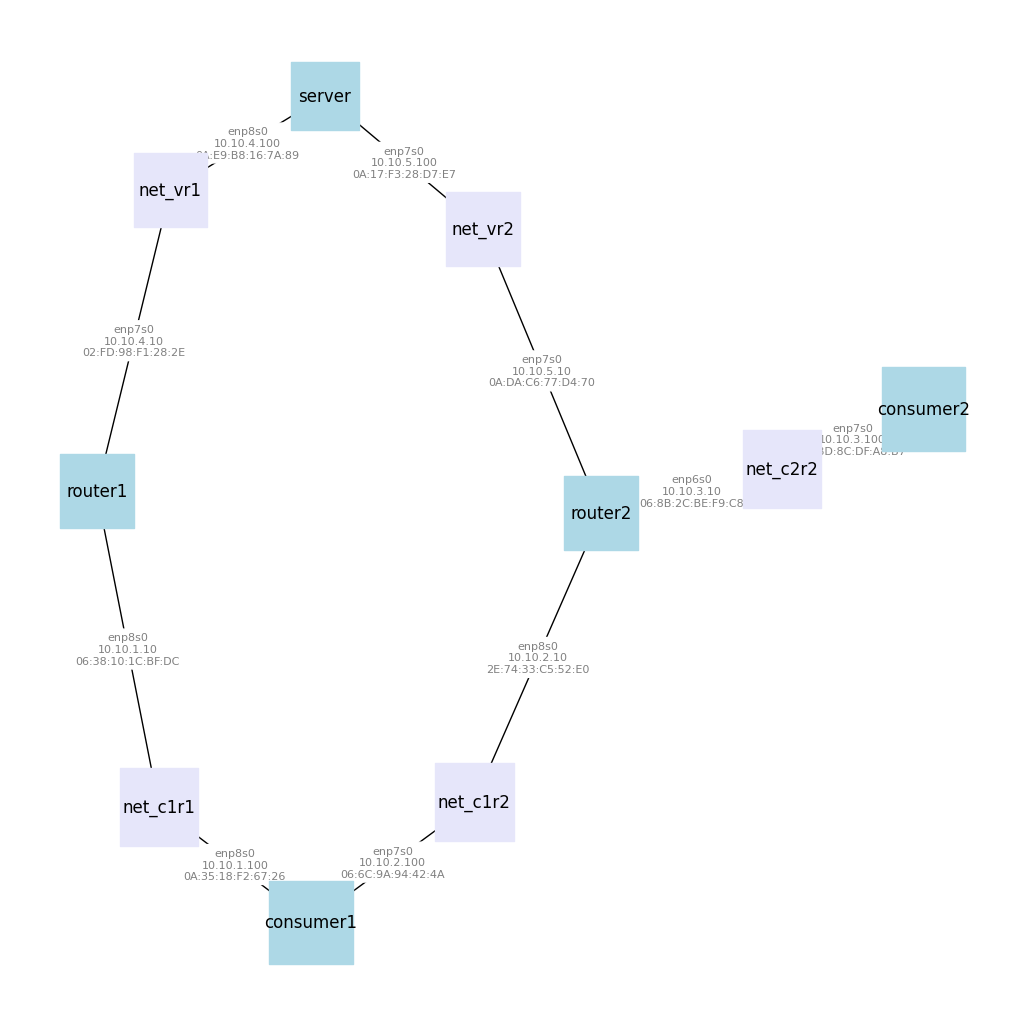

In [22]:
import networkx as nx
import matplotlib.pyplot as plt
plt.figure(figsize=(len(nodes),len(nodes)))
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)
pos = nx.spring_layout(G)
nx.draw(G, pos, node_shape='s',  
        node_color=[n[1]['color'] for n in nodes], 
        node_size=[len(n[0])*400 for n in nodes],  
        with_labels=True);

nx.draw_networkx_edge_labels(G, pos,
                             edge_labels=nx.get_edge_attributes(G,'label'),
                             font_color='gray',  font_size=8, rotate=False);

## Log into nodes
Get the ssh commands for the Consumers, Routers, and Server

In [17]:
import pandas as pd
pd.set_option('display.max_colwidth', None)
slice_info = [{'Name': n.get_name(), 'SSH command': n.get_ssh_command()} for n in slice.get_nodes()]
pd.DataFrame(slice_info).set_index('Name')

,SSH command
Name,
consumer1,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2001:1948:417:7:f816:3eff:fedd:ff5e
server,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@137.222.230.29
router1,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2001:400:a100:3060:f816:3eff:fe91:57e1


## Initialize MFLib object

In [ ]:
%%time
mf = MFLib(slice_name)

## Install Prometheus and Grafana

Install the 2 tools and then get the access information

In [ ]:
%%time
instrumetize_results = mf.instrumentize( ["prometheus"] )

In [ ]:
# Grafana SSH Tunnel Command
# mf.grafana_tunnel_local_port = 10010 # optionally change the port
print(mf.grafana_tunnel)

print(f"Browse to https://localhost:{mf.grafana_tunnel_local_port}/grafana/dashboards?query=%2A")

In [ ]:
# The grafana_manager service was created by the mf.instrumentize call.
# Get access info for Grafana by using the mflib.info call to the grafana_manager.
# Create a dictionary to pass to the service.
data = {}
# Set the info you want to get.
data["get"] = ["admin_password"]
# Call info using service name and data dictionary.
info_results = mf.info("grafana_manager", data)
print(info_results)

## Cleanup
Step to delete the slice

In [23]:
slice = fablib.get_slice(name=slice_name)
slice.delete()